In [1]:
import pandas as pd
import numpy as np
import math
import chart_studio.plotly as py
import plotly.tools as tls
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, mean_squared_error, f1_score, matthews_corrcoef, classification_report, roc_curve, auc



In [3]:
# Load model from file
#xnn_dir = '/home/kimm/article-information-2019/data/xnn_output/simulation_results/'
#xnn_dir = '/Users/kmontgomery/Documents/git/article-information-2019/data/xnn_output/simulation_results/'
xnn_dir = '/Users/phall/workspace/article-information-2019/data/xnn_output/simulation_results/'

filename = 'simulated_ann_results_with_Shapley.csv'

TEST = pd.read_csv(xnn_dir + filename)

Feature_names = ['binary1', 'binary2', 'cat1_0', 'cat1_1', 'cat1_2', 'cat1_3', 'cat1_4', 
                 'fried1_std', 'fried2_std', 'fried3_std', 'fried4_std', 'fried5_std']

In [4]:
TEST.columns

Index(['Unnamed: 0', 'binary1', 'binary2', 'ctrl_class1', 'ctrl_class2',
       'fold', 'intercept', 'latent_no_noise', 'latent_with_noise',
       'logistic_noise', 'outcome', 'outcome_no_noise', 'prot_class1',
       'prot_class2', 'cat1_0', 'cat1_1', 'cat1_2', 'cat1_3', 'cat1_4',
       'fried1_std', 'fried2_std', 'fried3_std', 'fried4_std', 'fried5_std',
       'probability', 'binary1_Shapley_score', 'binary2_Shapley_score',
       'cat1_0_Shapley_score', 'cat1_1_Shapley_score', 'cat1_2_Shapley_score',
       'cat1_3_Shapley_score', 'cat1_4_Shapley_score',
       'fried1_std_Shapley_score', 'fried2_std_Shapley_score',
       'fried3_std_Shapley_score', 'fried4_std_Shapley_score',
       'fried5_std_Shapley_score', 'Intercept_Shapley_score'],
      dtype='object')

In [5]:
def get_prauc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a pandas dataframe of y 
        and yhat values.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values.
        
    """
    
    frame_ = frame.copy(deep=True) # don't destroy original data
    dname = 'd_' + str(y)          # column for predicted decisions
    eps = 1e-20                    # for safe numerical operations
    
    # init p-r roc frame
    prroc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]

        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prroc_frame = prroc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
    
    # housekeeping
    del frame_
    
    return prroc_frame

# calculate and display recall and precision
#prauc_frame = get_prauc(test_yhat, y, yhat)
prauc_frame = get_prauc(TEST, 'outcome', 'probability')
prauc_frame.style.set_caption('Recall and Precision')

,cutoff,recall,precision,f1
0,0,1,0.49935,0.666089
1,0.01,1,0.5,0.666667
2,0.02,0.9998,0.504752,0.670832
3,0.03,0.999199,0.512401,0.677415
4,0.04,0.997597,0.519583,0.683286
5,0.05,0.995995,0.526436,0.688803
6,0.06,0.993992,0.533652,0.694463
7,0.07,0.99219,0.540619,0.699887
8,0.08,0.989787,0.548223,0.705618
9,0.09,0.987484,0.555637,0.711134


In [7]:
# Find the maximum F1 cutoff for the accuracy calculation
xnn_cut = prauc_frame.loc[prauc_frame['f1'].idxmax(), 'cutoff'] # value associated w/ index of max. F1
print('Best F1 threshold: %.2f' % xnn_cut)

Best F1 threshold: 0.38


In [9]:
# Calculate test statistics
Prediction = list(TEST['probability'])
Classification = list(TEST['probability'].apply(lambda x: int(x >= 0.38)))
Actual = list(TEST['outcome'].apply(int))

test_statistics = {}

#classification_rep = classification_report(Actual, Classification, output_dict=True)
classification_rep = classification_report(Actual, Classification, digits=3)

test_statistics['AUC'] = roc_auc_score(Actual, Prediction)
test_statistics['accuracy_score'] = accuracy_score(Actual, Classification)
test_statistics['log_loss'] = log_loss(Actual, Prediction)
test_statistics['rmse'] = math.sqrt(mean_squared_error(Actual, Prediction))
test_statistics['mcc'] = matthews_corrcoef(Actual, Classification)
#test_statistics['precision'] = classification_rep[1]['precision']
#test_statistics['sensitivity'] = classification_rep[1]['recall']
test_statistics['F1'] = f1_score(Actual, Classification)

print(test_statistics)

{'AUC': 0.8497210910286438, 'accuracy_score': 0.7572, 'log_loss': 0.48037561622732866, 'rmse': 0.39754676883124707, 'mcc': 0.5253507888843505, 'F1': 0.7792125125034102}


In [10]:
# recall of the positive class is also known as “sensitivity”
# recall of the negative class is “specificity”
print(classification_rep)

             precision    recall  f1-score   support

          0      0.823     0.657     0.730     10013
          1      0.714     0.858     0.779      9987

avg / total      0.768     0.757     0.755     20000



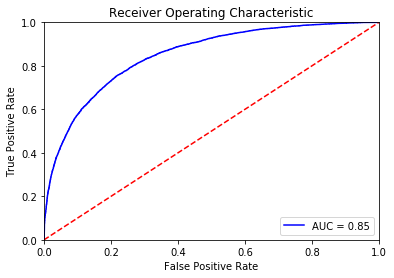

In [11]:
fpr, tpr, threshold = roc_curve(Actual, Prediction)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

